In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import math
import plotly.express as px
import plotly.graph_objects as go
import scipy.interpolate as interpolate
import matplotlib
matplotlib.rcParams.update({'font.size':15})
import os
import re
def hasNumbers(inputString):
    return bool(re.search(r'\d', inputString))

In [11]:
ffolder = 'Z:\\Jason Gao\\Satiety_behavior_JG_041921\\050821\\20210508-154659 JGWT1\\'
pybpod_file = [f for f in os.listdir(ffolder) if f.endswith(".csv") and hasNumbers(f)]
pybpod_data = pd.read_csv(ffolder + pybpod_file[0], skiprows=6, delimiter = ';')
trialtype_data= pd.read_csv(ffolder+'trialtype_data.csv', delimiter = ',', names =["ValveDuration","ITI","RewardType",'TrialNumber'])
rewardtype_data = [int(s) for s in trialtype_data.RewardType[0][4:-4].split(',')]


In [12]:
#Add a column for 'timestamps'
import time
import datetime
import ciso8601

timestamp = []
for i in range(len(pybpod_data.index)):
    t = pybpod_data['PC-TIME'].iloc[i]
    ts= ciso8601.parse_datetime(t)
    if i == 0:
        t0= time.mktime(ts.timetuple())+ts.microsecond/1000000
        timestamp.append(np.around(t0-t0,3))
    else:
        tnow = time.mktime(ts.timetuple())+ts.microsecond/1000000
        timestamp.append(np.around(tnow-t0,3))

pybpod_data['timestamps'] = timestamp
pybpod_data.head()
timestamp_max= np.int(np.round(np.max(timestamp)))
pybpod_data.head()
t0= time.mktime(ts.timetuple())+ts.microsecond/1000000
t0

1620506195.876347

In [13]:
df_group_info = pybpod_data.groupby('+INFO')
df_group_type = pybpod_data.groupby('TYPE')
df_group_MSG = pybpod_data.groupby('MSG')
df_group_type.first()

,PC-TIME,BPOD-INITIAL-TIME,BPOD-FINAL-TIME,MSG,+INFO,timestamps
TYPE,,,,,,
END-TRIAL,2021-05-08 15:47:02.266842,NaN,NaN,The trial ended,NaN,1.441
EVENT,2021-05-08 15:47:02.265845,1.00000,NaN,158,Tup,1.440
INFO,2021-05-08 15:47:00.825677,0.33193,1.331933,SERIAL-PORT,COM11,0.000
SOFTCODE,2021-05-08 15:47:04.273478,NaN,NaN,1,NaN,3.448
STATE,2021-05-08 15:47:02.266842,0.00000,1.000000,BNC1_CameraON,1.0,1.441
TRANSITION,2021-05-08 15:47:02.773488,0.50000,NaN,move_spout,NaN,1.948
TRIAL,2021-05-08 15:47:01.261512,NaN,NaN,New trial,NaN,0.436


In [14]:
# Find timestamps for BNC1_CameraON & BNC1_CameraOFF
df_bnc1high = df_group_MSG.get_group('BNC1_CameraON')
timestamp_bnc1_cameraon = df_bnc1high.timestamps.to_numpy()[0]

df_bnc1high = df_group_MSG.get_group('BNC1_CameraOFF')
timestamp_bnc1_cameraoff = df_bnc1high.timestamps.to_numpy()[0]

print(timestamp_bnc1_cameraon, timestamp_bnc1_cameraoff)
print(timestamp_bnc1_cameraoff-timestamp_bnc1_cameraon)

1.441 2975.05
2973.6090000000004


In [15]:
# Find Softcode Xonar Audio timestamps ('BNC1High'), process so no duplicates
df_bnc1high = df_group_info.get_group('BNC1High')
df_softcode = df_group_type.get_group('SOFTCODE')
a = df_bnc1high['timestamps'].diff().fillna(df_bnc1high['timestamps']) > 10
timestamps_bnc1high = df_bnc1high.loc[a].timestamps.to_numpy()


In [16]:
# Find HARP Audio timestmps
df_transition = df_group_type.get_group('TRANSITION')
timestamps_audio = df_transition[df_transition['MSG']=='trial_start'].timestamps.to_numpy()
timestamps_audio1 = timestamps_audio[[i for i, e in enumerate(rewardtype_data) if e == 1]]
timestamps_audio2 = timestamps_audio[[i for i, e in enumerate(rewardtype_data) if e == 2]]
timestamps_audio3 = timestamps_audio[[i for i, e in enumerate(rewardtype_data) if e == 3]]
timestamps_audio4 = timestamps_audio[[i for i, e in enumerate(rewardtype_data) if e == 4]]


In [17]:
# Find open_valve
timestamps_openvalve = df_transition[df_transition['MSG']=='open_valve'].timestamps.to_numpy()

In [18]:
# Get lick onsets & convert them to rate
df_port1out = df_group_info.get_group('Port1Out')
df_port2out = df_group_info.get_group('Port2Out')
df_port3out = df_group_info.get_group('Port3Out')
df_port4out = df_group_info.get_group('Port4Out')
# df_port1out.head()
timestamps_port1on = df_port1out.timestamps.to_numpy()
timestamps_port2on = df_port2out.timestamps.to_numpy()
timestamps_port3on = df_port3out.timestamps.to_numpy()
timestamps_port4on = df_port4out.timestamps.to_numpy()
timestamps_porton = np.concatenate([timestamps_port1on,timestamps_port2on,timestamps_port3on,timestamps_port4on])
# px.scatter(x = timestampes_lickon, y = np.ones(len(df_port1out)))

ms = 1
binsize = timestamp_max * ms
count_port1,d=np.histogram(timestamps_port1on,bins=binsize,range=[0, timestamp_max])
count_port2,d=np.histogram(timestamps_port2on,bins=binsize,range=[0, timestamp_max])
count_port3,d=np.histogram(timestamps_port3on,bins=binsize,range=[0, timestamp_max])
count_port4,d=np.histogram(timestamps_port4on,bins=binsize,range=[0, timestamp_max])
%store count_port1
%store count_port2
%store count_port3
%store count_port4

Stored 'count_port1' (ndarray)
Stored 'count_port2' (ndarray)
Stored 'count_port3' (ndarray)
Stored 'count_port4' (ndarray)


In [19]:
# Divide trials between Lick & Nolick trials
window_post = 4*ms

windowlicks = np.zeros(len(timestamps_audio1))
for i,j in enumerate(timestamps_audio1[:]):
    sumlick= np.sum(count_port1[int(j*ms):int(j*ms)+window_post])
    if sumlick> 0:
        windowlicks[i] = 1
timestamps_audio1succ = timestamps_audio1[windowlicks==1]
timestamps_audio1fail =  timestamps_audio1[windowlicks==0]

windowlicks = np.zeros(len(timestamps_audio2))
for i,j in enumerate(timestamps_audio2[:]):
    sumlick = np.sum(count_port1[int(j*ms):int(j*ms)+window_post])
    if sumlick > 0:
        windowlicks[i] = 1
timestamps_audio2succ = timestamps_audio2[windowlicks==1]
timestamps_audio2fail =  timestamps_audio2[windowlicks==0]

windowlicks = np.zeros(len(timestamps_audio3))
for i,j in enumerate(timestamps_audio3[:]):
    sumlick = np.sum(count_port1[int(j*ms):int(j*ms)+window_post])
    if sumlick > 0:
        windowlicks[i] = 1
timestamps_audio3succ = timestamps_audio3[windowlicks==1]
timestamps_audio3fail =  timestamps_audio3[windowlicks==0]

windowlicks = np.zeros(len(timestamps_audio4))
for i,j in enumerate(timestamps_audio4[:]):
    sumlick = np.sum(count_port1[int(j*ms):int(j*ms)+window_post])
    if sumlick > 0:
        windowlicks[i] = 1
timestamps_audio4succ = timestamps_audio4[windowlicks==1]
timestamps_audio4fail =  timestamps_audio4[windowlicks==0]

In [20]:
# %store -r speed1s
# fig, ax = plt.subplots(figsize=(20,3))
# ax_twin = ax.twinx()
# ax.set_title("Water 20210425-165110 Phox2b 8")
# ax.set_ylabel('Licks/s')
# ax.set_xlabel('Time (s)')
# ax_twin.set_ylabel('Speed (cm/s)')

# ax.plot(count_port4,'k')
# ax_twin.plot(speed1s,'r')
# ax_twin.set_ylim([0, 10])
# ax.set_ylim([0, 13])
# # for i,j in enumerate(timestamps_openvalve):
# #     line0 = ax.axvline(j, color ='b', linestyle = '--')
# # ax.legend([np.size(timestamps_openvalve)])

# # fig.savefig('20210425-161426 Phox2b6 Water Spontaneous.pdf')

In [21]:
# fig = px.line(count_port4)
# for i,j in enumerate(timestamps_openvalve):
#     fig.add_shape(type='line',
#                 yref="y",
#                 xref="x",
#                 x0=j,
#                 y0=0,
#                 x1=j,
#                 y1=10,
#                 line=dict(color='black', width=0.5))
# fig.show()

Stored 'time_ms' (ndarray)


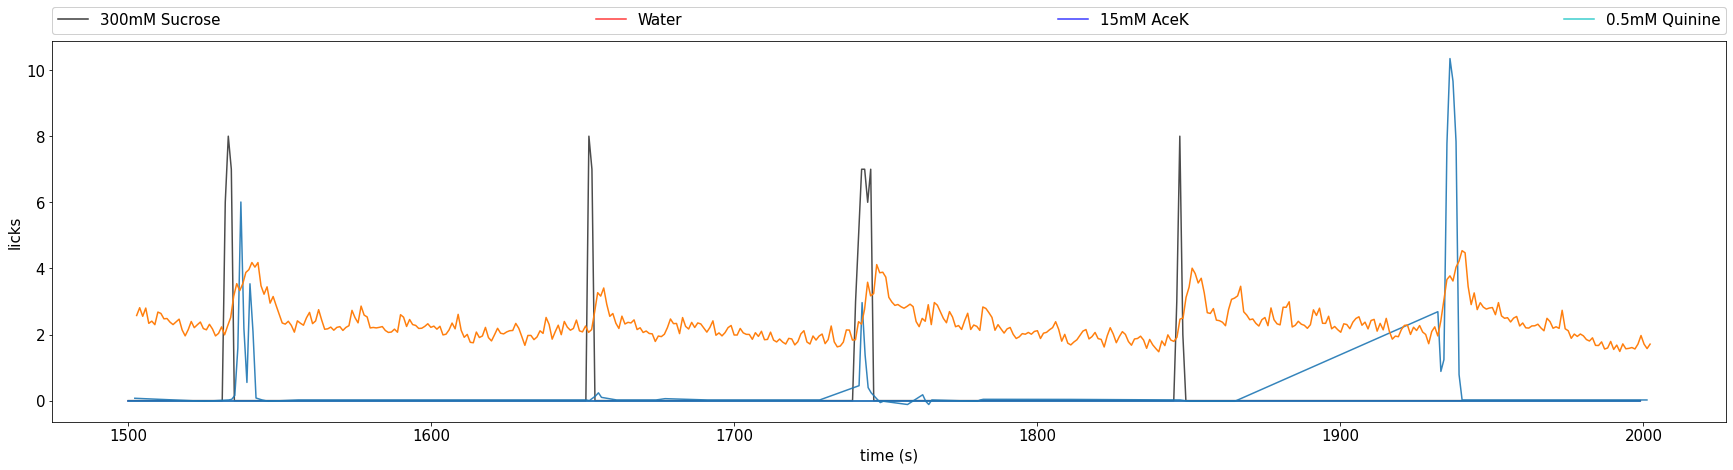

In [22]:

%store -r speed1s
%store -r speed1ms
%store -r time_speed1s
%store -r pupil1s
%store -r time_pupil1s
time_ms = np.arange(0,timestamp_max,1)
# time_ms_speed1ms = np.arange(0,1192,1/1000)

window = np.arange(1500,2000)
fig, ax = plt.subplots(figsize=(30,7))
ax.plot(time_ms[window], count_port1[window],label='300mM Sucrose',color ='k',alpha = 0.7)
ax.plot(time_ms[window],count_port2[window],label='Water',color ='r',alpha = 0.7)
ax.plot(time_ms[window],count_port3[window],label='15mM AceK',color ='b',alpha = 0.7)
ax.plot(time_ms[window],count_port4[window],label='0.5mM Quinine',color ='c',alpha = 0.7)
ax.set_xlabel('time (s)')
ax.set_ylabel('licks')
legend1 = plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=4)
ax.add_artist(legend1)
ax.plot(time_speed1s[window], speed1s[window],alpha = 0.9)
ax.plot(time_pupil1s[window], pupil1s[window]*5)
# ax.plot(timestamps_bnc1high, traces1_norm[0])
#NeuronNumber : 2,3,7,8,10,11,12,14,15,17,18,19, remember i+1=Nnumber
%store time_ms

In [23]:
print(time_pupil1s[0:10])
print(time_ms[0:10])
print(time_speed1s[0:10])

[ 1.441       2.44187816  3.44275631  4.44363447  5.44451262  6.44539078
  7.44626893  8.44714709  9.44802524 10.4489034 ]
[0 1 2 3 4 5 6 7 8 9]
[ 2.152  3.152  4.152  5.152  6.152  7.152  8.152  9.152 10.152 11.152]


In [24]:
total_port = timestamps_port1on.size+timestamps_port2on.size+timestamps_port3on.size+timestamps_port4on.size
print('total licks   :',total_port)
print('300mM Sucrose :', timestamps_port1on.size)
print('Water         :', timestamps_port2on.size)
print('15mM AceK     :', timestamps_port3on.size)
print('Water         :', timestamps_port4on.size)

total licks   : 614
300mM Sucrose : 570
Water         : 3
15mM AceK     : 8
Water         : 33


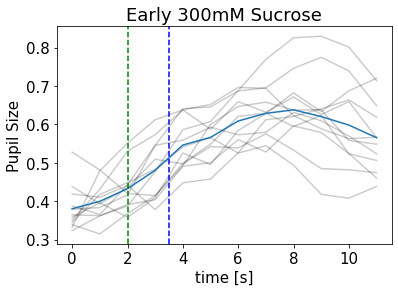

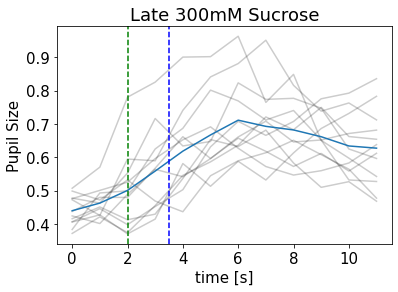

In [255]:
#Raster Licks
window_pre = 2*ms
window_post = 10*ms

raster_speed = np.zeros((len(timestamps_audio1succ[:12]),window_pre+window_post))
# colors = plt.cm.copper(np.linspace(0,1,len(timestamps_audio1succ)))
for i,j in enumerate(timestamps_audio1succ[:12]):
    raster_speed[i] = (pupil1s[int(j*ms)-window_pre:int(j*ms)+window_post])
    plt.plot(raster_speed[i],color ='k',alpha=0.2)
# plt.imshow(raster_speed, aspect = 'auto', cmap='Greys')
plt.plot(np.mean(raster_speed, 0))
plt.axvline(2*ms, color ='g', linestyle = '--')
plt.axvline(3.5*ms, color ='b', linestyle = '--')
plt.ylabel('Pupil Size')
plt.xlabel('time [s]')
# plt.xticks([0,1,2,3,4,5,6]*ms,[-2,-1,0,1,2,3,4]*ms)
plt.title('Early 300mM Sucrose')
plt.show()

raster_speed = np.zeros((len(timestamps_audio1succ[12:]),window_pre+window_post))
# colors = plt.cm.copper(np.linspace(0,1,len(timestamps_audio1succ)))
for i,j in enumerate(timestamps_audio1succ[12:]):
    raster_speed[i] = (pupil1s[int(j*ms)-window_pre:int(j*ms)+window_post])
    plt.plot(raster_speed[i],color ='k',alpha=0.2)
# plt.imshow(raster_speed, aspect = 'auto', cmap='Greys')
plt.plot(np.mean(raster_speed, 0))
plt.axvline(2*ms, color ='g', linestyle = '--')
plt.axvline(3.5*ms, color ='b', linestyle = '--')
plt.ylabel('Pupil Size')
plt.xlabel('time [s]')
# plt.xticks([0,1,2,3,4,5,6]*ms,[-2,-1,0,1,2,3,4]*ms)
plt.title('Late 300mM Sucrose')
plt.show()

# raster_speed = np.zeros((len(timestamps_audio2succ),window_pre+window_post))
# for i,j in enumerate(timestamps_audio2succ[0:-1]):
#     raster_speed[i] = (count_port2[int(j*ms)-window_pre:int(j*ms)+window_post])
#     plt.plot(raster_speed[i],color='k',alpha=0.2)
# # plt.imshow(raster_speed, aspect = 'auto', cmap='Greys', vmax=1)
# plt.plot(np.mean(raster_speed, 0))
# plt.axvline(2*ms, color ='g', linestyle = '--')
# plt.axvline(3.5*ms, color ='b', linestyle = '--')
# plt.ylabel('Licks/s')
# plt.xlabel('time [s]')
# # plt.xticks([0,1,2,3,4,5,6]*ms,[-2,-1,0,1,2,3,4]*ms)
# plt.title('Water')
# plt.show()

# raster_speed = np.zeros((len(timestamps_audio3succ),window_pre+window_post))
# for i,j in enumerate(timestamps_audio3succ[0:-1]):
#     raster_speed[i] = (count_port3[int(j*ms)-window_pre:int(j*ms)+window_post])
#     plt.plot(raster_speed[i],color='k',alpha=0.2)
# # plt.imshow(raster_speed, aspect = 'auto', cmap='Greys', vmax=1)
# plt.plot(np.mean(raster_speed, 0))
# plt.axvline(2*ms, color ='g', linestyle = '--')
# plt.axvline(3.5*ms, color ='b', linestyle = '--')
# plt.ylabel('Licks/s')
# plt.xlabel('time [s]')
# # plt.xticks([0,1,2,3,4,5,6]*ms,[-2,-1,0,1,2,3,4]*ms)
# plt.title('15mM AceK')
# plt.show()

# raster_speed = np.zeros((len(timestamps_audio4succ),window_pre+window_post))
# for i,j in enumerate(timestamps_audio4succ[0:-1]):
#     raster_speed[i] = (count_port4[int(j*ms)-window_pre:int(j*ms)+window_post])
#     plt.plot(raster_speed[i],color='k',alpha=0.2)
# # plt.imshow(raster_speed, aspect = 'auto', cmap='Greys', vmax=1)
# plt.plot(np.mean(raster_speed, 0))
# plt.axvline(2*ms, color ='g', linestyle = '--')
# plt.axvline(3.5*ms, color ='b', linestyle = '--')
# plt.ylabel('pupil size')
# plt.xlabel('time [s]')
# # plt.xticks([0,1,2,3,4,5,6]*ms,[-2,-1,0,1,2,3,4]*ms)
# plt.title('0.5mM Quinine')
# plt.show()

# raster_speed = np.zeros((len(timestamps_audio1[:-1]),6000))
# for i,j in enumerate(timestamps_audio1[:-1]):
#     raster_speed[i] = speed1ms[int(j*1000)-1000:int(j*1000)+5000]
#     plt.plot(raster_speed[i],color='k',alpha=0.2)
# # plt.plot(np.mean(raster_speed, 0))
# plt.legend(loc="lower right")
# plt.axvline(1000, color ='g', linestyle = '--')
# plt.axvline(2500, color ='b', linestyle = '--')
# plt.ylabel('Speed [cm/s]')
# plt.xlabel('time [s]')
# plt.xticks([0,1000,2000,3000,4000,5000,6000],[-1,0,1,2,3,4,5])

In [237]:
len(timestamps_audio1succ)

53

In [51]:
fig = go.Figure()

# fig.add_trace(go.Scatter(x = np.arange(24000)/10, y= count_lickrate,
#                     mode='lines', line = dict(color = 'black'),
#                     name='Lickrate'))
fig.add_trace(go.Scatter(x=np.arange(1,len(speed1s)), y= speed1s,
                    mode='lines',
                    name='Speed'))
# for i,j in enumerate(timestamps_bnc1high):
#     fig.add_vline(x= timestamps_bnc1high[i], line_width=1, line_dash="dash", line_color="green", name = 'AudioCue')
fig.update_layout(title="Raw Behavior Trace",
    xaxis_title="time [s]",
    yaxis_title="speed [cm/s]",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="black"
    ), plot_bgcolor ='white',autosize=False,
    width=1000,
    height=500,)
fig.show()
              

NameError: name 'speed1s' is not defined

In [ ]:
plt.plot(count_lickrate)
plt.plot(raw_encoderdata1000ms.EVT_TIME/1000, raw_encoderdata1000ms.VALUE)

In [ ]:
traces = np.load('trace.npy')
#NeuronNumber : 2,3,7,8,10,11,12,14,15,17,18,19, remember i-1=Nnumber

In [ ]:
np.shape(traces[0])

In [ ]:
#Find BNC1High = 3p frames
df_bnc1high = df_group_info.get_group('BNC1High')
timestamps_bnc1high = df_bnc1high.timestamps.to_numpy()
timestamps_bnc1high.size

#More 3p frames than BNC1High. Cut off the last frames not shown in BNC1High


In [ ]:
# #When including all traces from Caiman
# traces1 = np.zeros((np.shape(traces)[0], timestamps_bnc1high.size))
# for i in range(np.shape(traces)[0]):
#     traces1[i,:] = traces[i,:timestamps_bnc1high.size]

#Only inclde manually checked traces 
celln = [2,3,7,8,10,11,12,14,15,18,19]
celln = [celln - 1 for celln in celln]
traces1 = np.zeros((np.shape(celln)[0], timestamps_bnc1high.size))
traces1_norm = np.zeros((np.shape(celln)[0], timestamps_bnc1high.size))
for i,j in enumerate(celln):
    traces1[i,:] = traces[j,:timestamps_bnc1high.size]
    traces1_norm[i,:] = traces1[i,:]/np.max(traces1[i,:])

In [ ]:
timestamps_bnc1high[2000]
time_ms = np.arange(0,1200,1/1000)
time_ms_speed1ms = np.arange(0,1192,1/1000)
time_s_speed1s = np.arange(0,1193)
window = np.arange(0,614372)

In [ ]:
timestamps_port1on[timestamps_port1on < 614.372]

In [ ]:
fig, ax = plt.subplots(figsize=(25,10))
for i in range(np.shape(traces1_norm)[0]):
    ax.plot(timestamps_bnc1high[0:2000], traces1_norm[i][0:2000]+i,color='k',linewidth = 2)
plt.ylabel('Normalized DF/F')
plt.xlabel('time [s]')


fig, ax = plt.subplots(figsize=(20,1))
ax.plot(time_ms_speed1ms[window], speed1ms[window], linewidth = 2)
plt.ylabel('Speed [m/s]')
plt.xlabel('time [s]')

fig, ax = plt.subplots(figsize=(20,1))
for i,j in enumerate(timestamps_audio[timestamps_audio < 614.372]):
    ax.axvline(j, color ='k', linestyle = '--')
for i,j in enumerate(timestamps_port1on[timestamps_port1on < 614.372]):
    ax.axvline(j, color ='b', linestyle = '-',alpha=0.1)
for i,j in enumerate(timestamps_port2on[timestamps_port2on < 614.372]):
    ax.axvline(j, color ='orange', linestyle = '-',alpha=0.1)
for i,j in enumerate(timestamps_port3on[timestamps_port3on < 614.372]):
    ax.axvline(j, color ='g', linestyle = '-',alpha=0.1)
for i,j in enumerate(timestamps_port4on[timestamps_port4on < 614.372]):
    ax.axvline(j, color ='r', linestyle = '-',alpha=0.1)
plt.xlabel('time [s]')

In [ ]:
from matplotlib.gridspec import GridSpec

fig, ax = plt.subplots(figsize=(20,15))
plt.yticks([])
plt.xticks([])
heights = [7,0.2,1,0.3, 1]
gs = GridSpec(nrows=5, ncols=1, height_ratios = heights)

ax0 = fig.add_subplot(gs[0,0])
for i in range(np.shape(traces1_norm)[0]):
    ax0.plot(timestamps_bnc1high[0:2000], traces1_norm[i][0:2000]+i,color='k',linewidth = 2)
ax0.set_ylabel('Normalized DF/F')
ax0.set_xlabel('time [s]')

ax1 = fig.add_subplot(gs[2,0])
ax1.plot(time_ms_speed1ms[window], speed1ms[window], linewidth = 2)
ax1.set_ylabel('Speed [m/s]')
ax1.set_xlabel('time [s]')
ax1.set_yticks([0, 5, 10])

ax2 = fig.add_subplot(gs[4,0])
for i,j in enumerate(timestamps_port1on[timestamps_port1on < 614.372]):
    line1 = ax2.axvline(j, color ='b', linestyle = '-',alpha=0.1)
for i,j in enumerate(timestamps_port2on[timestamps_port2on < 614.372]):
    line2 = ax2.axvline(j, color ='orange', linestyle = '-',alpha=0.1)
for i,j in enumerate(timestamps_port3on[timestamps_port3on < 614.372]):
    line3 = ax2.axvline(j, color ='g', linestyle = '-',alpha=0.1)
for i,j in enumerate(timestamps_port4on[timestamps_port4on < 614.372]):
    line4 = ax2.axvline(j, color ='r', linestyle = '-',alpha=0.1)
for i,j in enumerate(timestamps_audio[timestamps_audio < 614.372]):
    line0 = ax2.axvline(j, color ='k', linestyle = '--')
ax2.set_ylabel('Events')
ax2.legend((line0, line1, line2, line3, line4),('Cue','Water','50mM Sucrose','200mM Sucrose','Water'),bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=5)

plt.xlabel('time [s]')
fig.savefig('Traces.pdf')

In [ ]:
file_name = 'AP1.xlsx'
xl_file = pd.read_excel(file_name)

In [ ]:
plt.plot(xl_file.Mean)